[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Office\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Office\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Office\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


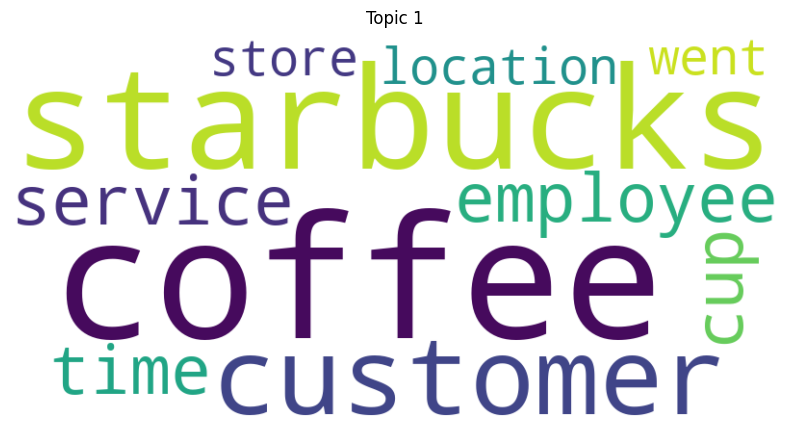

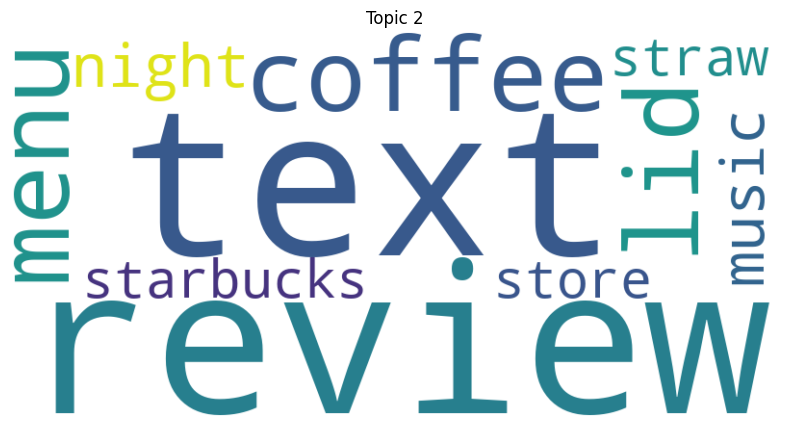

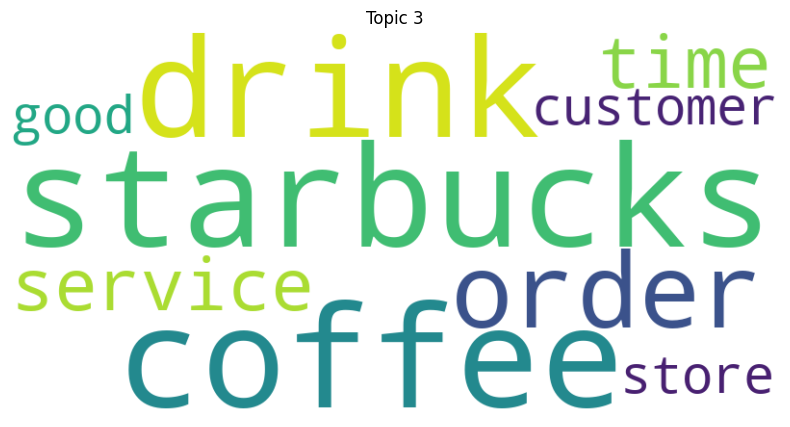

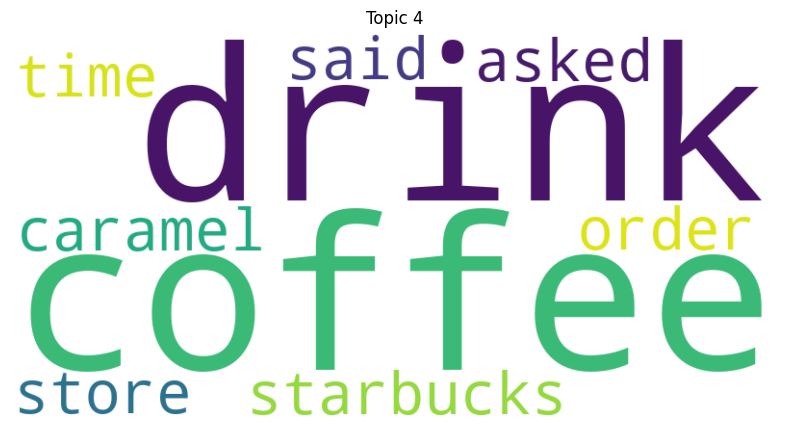

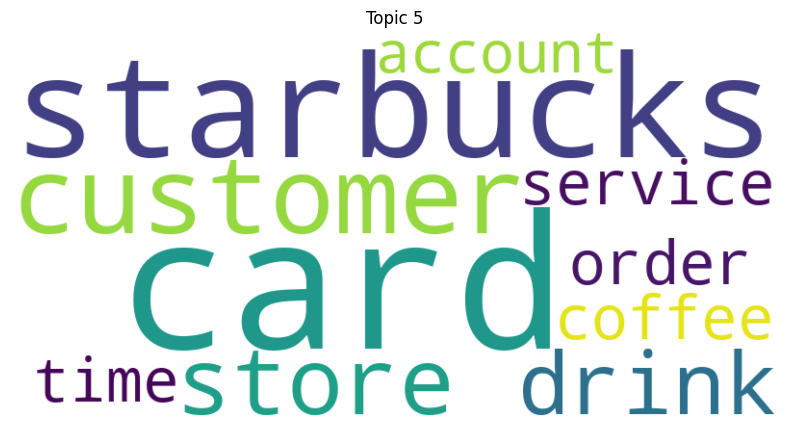

Sentiment Analysis Accuracy: 0.8529411764705882


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("reviews_data.csv")

# Data Preprocessing
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic characters, and lemmatize
    clean_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]
    return " ".join(clean_tokens)

df['clean_review'] = df['Review'].apply(preprocess_text)

# Sentiment Analysis
# Assuming 'Rating' column represents sentiment (1 to 5 scale), let's convert it to binary sentiment (positive or negative)
df['sentiment'] = df['Rating'].apply(lambda x: 'positive' if x > 3 else 'negative')

# Topic Modeling
# Convert text to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_review'])

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Get the top words for each topic
def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return top_words

# Visualize the topics using word clouds
def visualize_topics(top_words):
    for i, words in enumerate(top_words):
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Topic ' + str(i+1))
        plt.axis('off')
        plt.show()

feature_names = tfidf_vectorizer.get_feature_names_out()
top_words = get_top_words(lda, feature_names, 10)
visualize_topics(top_words)

# Splitting the data into train and test sets for sentiment analysis
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment'], test_size=0.2, random_state=42)

# Train a Random Forest classifier for sentiment analysis
tfidf_vectorizer_sentiment = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_train_tfidf = tfidf_vectorizer_sentiment.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer_sentiment.transform(X_test)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Sentiment Analysis Accuracy:", accuracy)



